# Set subject model.

In [1]:
#must be unique.
model_name = 'Final_Model_1'
epoch_select = 1000

# Imports and model init

In [2]:
#imports

import torch
import matplotlib.pyplot as plt
import numpy as np
import time, os, pickle
import pandas as pd


import init
import loader
import visualisation
import parameters
import ipynb_utils
import sys
from serial import RNN
from b_vae import B_VAE
from autoencoders import vae
import matplotlib.colors as colors
import matplotlib.cm as cmx
sys.path.append('../../libs/')
import shjnn

# Initalize Model




# Load the model
saves_folder = "saves"
model_subfolder = None

if os.path.exists(saves_folder):
    for subfolder in os.listdir(saves_folder):
        subfolder_path = os.path.join(saves_folder, subfolder)
        if os.path.isdir(subfolder_path) and model_name in subfolder:
            model_subfolder = os.path.join(subfolder_path, "model")
            break

# Check for Pickle and PTH files
pickle_file = None
pth_files = []
for file in os.listdir(model_subfolder):
    if file.endswith(".pkl"):
        pickle_file = os.path.join(model_subfolder, file)
        print(f"(1/4) Found Config file: {pickle_file}")
        
    elif file.endswith(".pth"):
        pth_file = os.path.join(model_subfolder, file)
        pth_files.append(pth_file)
if not pickle_file or not pth_files:
    print(f"Pickle file or PTH file not found in '{model_subfolder}'.")
    raise FileNotFoundError(f"Pickle file or PTH file not found in '{model_subfolder}'.")

if pth_files:
    print(f"(2/4) Found Model Saves")
# Load the model configuration
loaded = None
with open(pickle_file, 'rb') as f:
    try:
        loaded = pickle.load(f)
    except EOFError:
        pass
assert len(loaded) == 17


parameters.dataset = loaded[0]
parameters.dataset_PV = loaded[1]
parameters.trainer = loaded[2]
parameters.model = loaded[3]
parameters.rnn = loaded[4]
parameters.b_vae = loaded[5]
parameters.load_check = loaded[6]
parameters.model_params = loaded[7]
parameters.vae_params = loaded[8]
parameters.records = loaded[9]
parameters.device = loaded[10]
parameters.amp = loaded[11]
parameters.freq = loaded[12]
parameters.adaptive_training = loaded[13]
parameters.save = loaded[14]
parameters.split = loaded[15]
parameters.gridsearch = loaded[16]

assert parameters.load_check == True
print(f"(3/4) Loaded Config")

#load the model.
model_params = parameters.model_params
dev = torch.device(parameters.device)
if epoch_select is None:
    path = pth_files[-1]  # Use the last file in the list
else:
    path = [f for f in pth_files if f"{epoch_select}" in f]
    if not path:
        raise FileNotFoundError(f"No PTH file found for epoch {epoch_select}.")
    path = path[0]
assert model_params['func'] is not None
try:
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])
except (ImportError, AttributeError):
    pass
shjnn.load_state(path, model_params['func'], model_params['rec'], decoder = model_params['dec'], optimizer = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)
print(f"(4/4) Loaded Model from {path}")

print("---Success--- Model and parameters loaded successfully.")

(1/4) Found Config file: saves/20250529-174140_Final_Model_1_/model/parameters.pkl
(2/4) Found Model Saves
(3/4) Loaded Config
(4/4) Loaded Model from saves/20250529-174140_Final_Model_1_/model/save_model_ckpt_1000.pth
---Success--- Model and parameters loaded successfully.


# Visualisations

In [12]:
# check performance

parameters.model.eval(parameters.model_params, parameters.dataset)

logs: b_vae: eval: evaluating over 150 samples.
logs: b_vae: eval: batch 1/10, avg loss: 0.695969
logs: b_vae: eval: batch 2/10, avg loss: 0.843598
logs: b_vae: eval: batch 3/10, avg loss: 0.976717
logs: b_vae: eval: batch 4/10, avg loss: 0.940352
logs: b_vae: eval: batch 5/10, avg loss: 1.081175
logs: b_vae: eval: batch 6/10, avg loss: 0.950232
logs: b_vae: eval: batch 7/10, avg loss: 0.876646
logs: b_vae: eval: batch 8/10, avg loss: 1.242888
logs: b_vae: eval: batch 9/10, avg loss: 0.883292
logs: b_vae: eval: batch 10/10, avg loss: 0.772912
logs: b_vae: eval: mean loss over 150 samples: 0.9366091533501943 at epoch 1000.


np.float64(0.9366091533501943)

Function to get sweeps through the dataset along a specific axis.

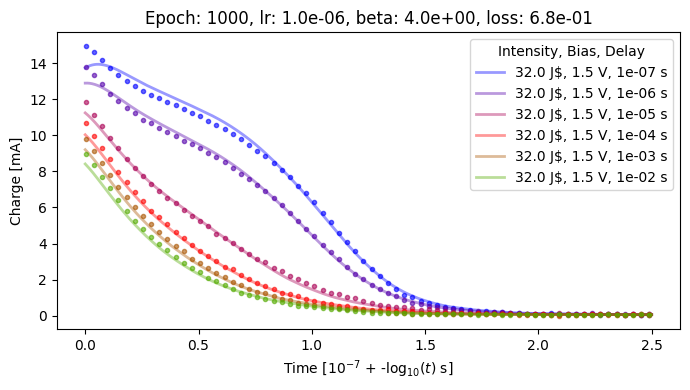

In [12]:
# Run model inference and visualisation along different parameters

# select models to plot ('intensity', 'voltage', or 'delay')
plot_models = ipynb_utils.get_sweep_index(122, 'delay')  # Example: sweep based on intensity from the first index

parameters.model_params['plot'] = plot_models
visualisation.display_random_fit(parameters.model_params, parameters.dataset, show=True, save=False, random_samples=False)

In [27]:
def run_and_save_inference_all_trajectories(model_params, dataset, save_dir=None, save_individual=True, save_batch=True):
    """
    Run and save inference for every trajectory in the dataset.
    
    Parameters
    ----------
    model_params : dict
        Dictionary containing model parameters and components
        Required keys: 'func', 'rec', 'dec', 'optim', 'device', 'epochs', 'folder'
    dataset : dict
        Dictionary containing dataset components
        Required keys: 'trajs', 'times', 'y'
    save_dir : str, optional
        Directory to save results. If None, uses model_params['folder'] + '/inference_results'
    save_individual : bool, default=True
        Whether to save individual trajectory inference results
    save_batch : bool, default=True
        Whether to save batch inference results
        
    Returns
    -------
    dict
        Dictionary containing inference results for all trajectories
    """
    # Extract data from dataset
    trajectories = dataset['trajs']
    time_points = dataset['times']
    metadata = dataset['y']
    
    # Extract model components
    model_func = model_params['func']
    encoder = model_params['rec']
    decoder = model_params['dec']
    optimizer = model_params['optim']
    device = model_params['device']
    epoch_num = model_params['epochs']
    
    # Set up save directory
    if save_dir is None:
        save_dir = model_params['folder'] + '/inference_results'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    # Create inference function
    infer_step = shjnn.make_infer_step(
        model_func, encoder, decoder, optimizer, device, 
        input_mode='traj', sample=False
    )
    
    # Create time points for prediction
    pred_times = np.linspace(0, 2.5, 1000) + 1  # +1 accounts for time bias
    time_tensor = torch.Tensor(pred_times).to(device)
    
    # Storage for results
    all_predictions = []
    all_latent_vectors = []
    all_losses = []
    trajectory_indices = list(range(len(trajectories)))
    
    print(f"Running inference on {len(trajectories)} trajectories...")
    
    # Process each trajectory
    for idx in trajectory_indices:
        # Prepare trajectory tensor
        traj_tensor = trajectories[idx].view(1, *trajectories[idx].size()).to(device)
        
        # Run model inference for prediction
        pred_x, pred_z = infer_step(traj_tensor, time_tensor)
  
        # Convert to numpy for storage
        pred_x_np = pred_x.detach().cpu().numpy()[0]
        pred_z_np = pred_z.detach().cpu().numpy()[0]
        
        # Store results
        all_predictions.append(pred_x_np)
        all_latent_vectors.append(pred_z_np)
        
        
    
    # Convert lists to numpy arrays
    all_predictions = np.stack(all_predictions)
    all_latent_vectors = np.stack(all_latent_vectors)
    
    print(f"Inference complete. Shapes - Predictions: {all_predictions.shape}, Latent: {all_latent_vectors.shape}")
    
    return all_predictions
    

def get_mean_property_plot(model_params, dataset, show=True):
    """
    Get a mapping of mean property values for each sweep axis 'intensity', 'voltage', or 'delay' on 3 different plots.
    """
    val_map = {
            # intensity in uJ
            'intensity': {'source': 'int',
                        'dark': 0., '32uJ': 32., '10uJ': 10., '3uJ': 3., '1uJ': 1., '03uJ': .3},
            # voltage in V
            'voltage': {'source': 'vlt',
                        '05V': .5, '0V': 0., '15V': 1.5, '1V': 1., '2V': 2.},
            # delay time in log10(s)
            'delay': {'source': 'del',
                    '100ns': 1e-7, '100us': 1e-4, '10ms': 1e-2, '10us': 1e-5, '1ms': 1e-3, '1us': 1e-6,
                    '200ns': 2e-7, '200us': 2e-4, '20ms': 2e-2, '20us': 2e-5, '2ms': 2e-3, '2us': 2e-6,
                    '500ns': 5e-7, '500us': 5e-4, '50ms': 5e-2, '50us': 5e-5, '5ms': 5e-3, '5us': 5e-6,
                    },
        }
    
    # Use run_and_save_inference_all_trajectories for comprehensive inference
    all_predictions = run_and_save_inference_all_trajectories(model_params, dataset)
    all_predictions = all_predictions.squeeze()
    # for each value in one sweep axis, get the mean trajectory of all trajectories with that value in the sweep axis.
    mean_map = {
            # intensity in uJ
            'intensity': {
                        0: [], 32: [], 10: [], 3: [], 1: [], 0.3: []},
            # voltage in V
            'voltage': {'source': 'vlt',
                        0.5: [], 0: [], 1.5: [], 1: [], 2: []},
            # delay time in log10(s)
            'delay': {'source': 'del',
                    1e-7: [], 1e-4: [], 1e-2: [], 1e-5: [], 1e-3: [], 1e-6: [],
                    2e-7: [], 2e-4: [], 2e-2: [], 2e-5: [], 2e-3: [], 2e-6: [],
                    5e-7: [], 5e-4: [], 5e-2: [], 5e-5: [], 5e-3: [], 5e-6: []
                    },
        }
    # append 
    for i, meta in enumerate(dataset['y']):
        meta_cpu = meta.cpu()
        mean_map['intensity'][meta_cpu[0]].append(all_predictions[i])
        mean_map['voltage'][meta_cpu[1]].append(all_predictions[i])
        mean_map['delay'][meta_cpu[2]].append(all_predictions[i])
    
    # plot each.
    cmap = plt.get_cmap('viridis')
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, (key, value) in enumerate(mean_map.items()):
        ax = axs[i]
        n_groups = len(value)
        colors = cmap(np.linspace(0, 1, n_groups))
        for sub_key, trajectories in value.items():
            if len(trajectories) > 0:
                mean_trajectory = np.mean(trajectories, axis=0)
                ax.plot(
                    mean_trajectory,
                    label=f"{sub_key} {val_map[key]['source']}",
                    color=colors[j],        # explicit color
                    linewidth=2,
                    alpha=0.8
                )
        
        ax.set_title(f"Mean Trajectories for {key.capitalize()}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Intensity")
        ax.legend()

In [ ]:
get_mean_property_plot(parameters.model_params, parameters.dataset, show=True)

Running inference on 150 trajectories...


# Latent Init

In [3]:
latent, all = ipynb_utils.get_latent_vectors(model_params, parameters.dataset, traj_idx=None)

Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


# Sweep latent dimensions

---Visualising Latent Dimension 0---


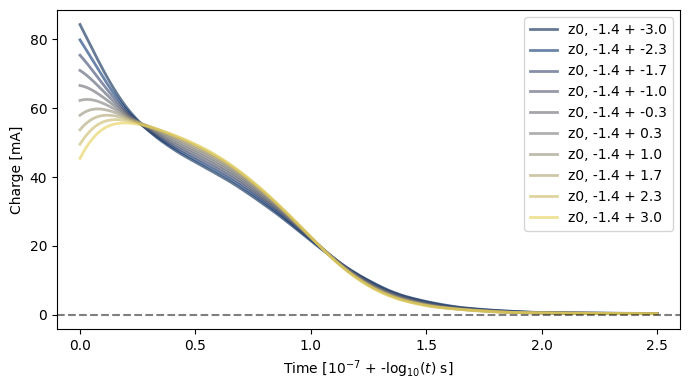

---Visualising Latent Dimension 1---


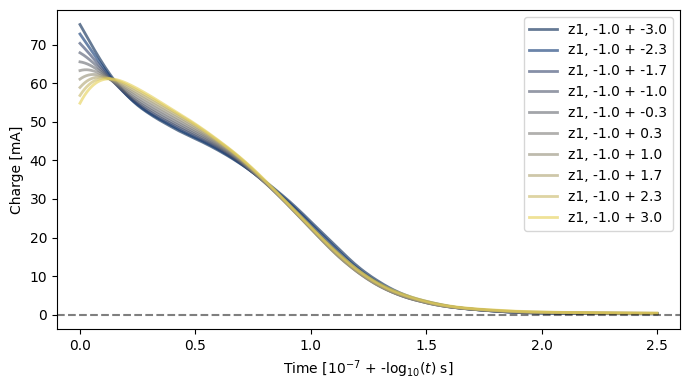

---Visualising Latent Dimension 2---


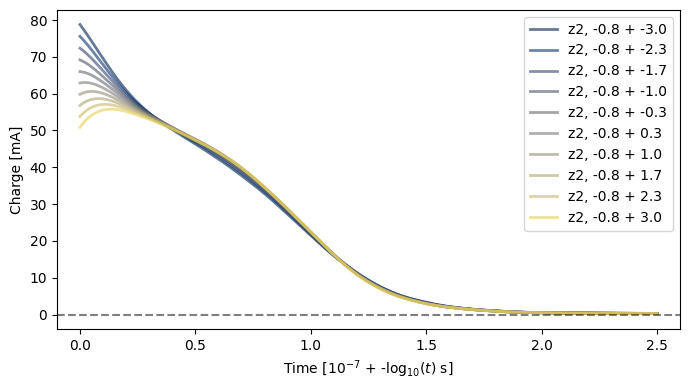

---Visualising Latent Dimension 3---


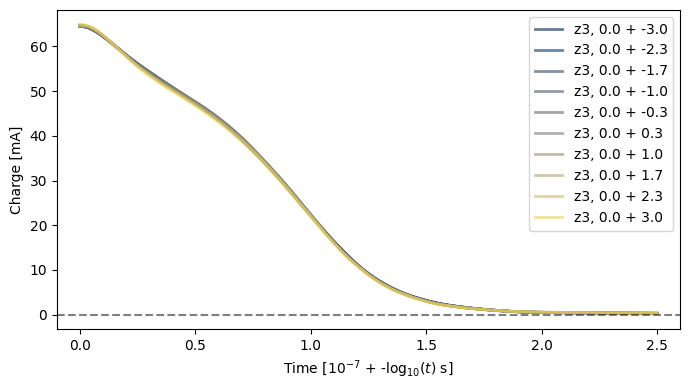

---Visualising Latent Dimension 4---


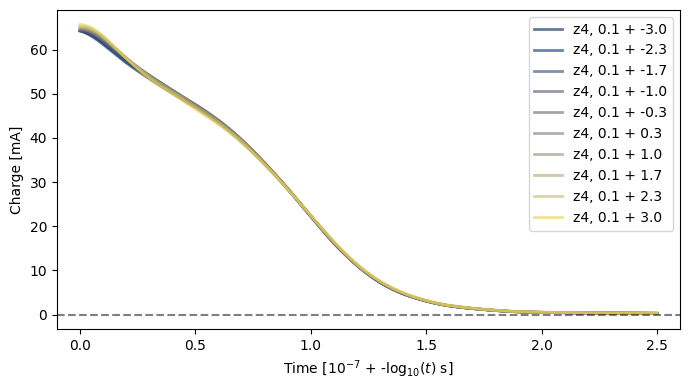

---Visualising Latent Dimension 5---


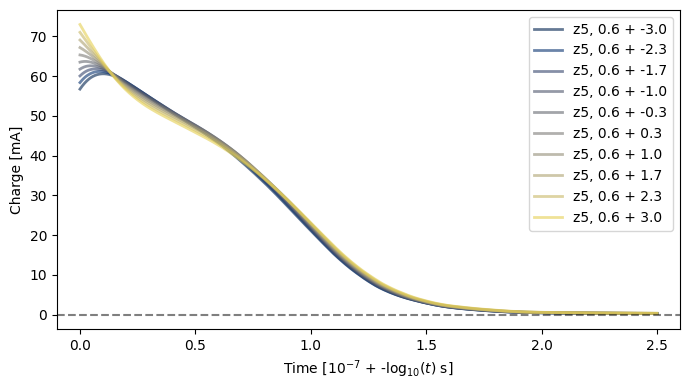

---Visualising Latent Dimension 6---


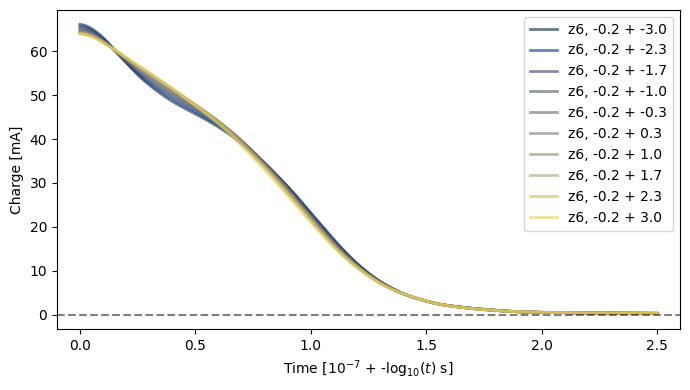

---Visualising Latent Dimension 7---


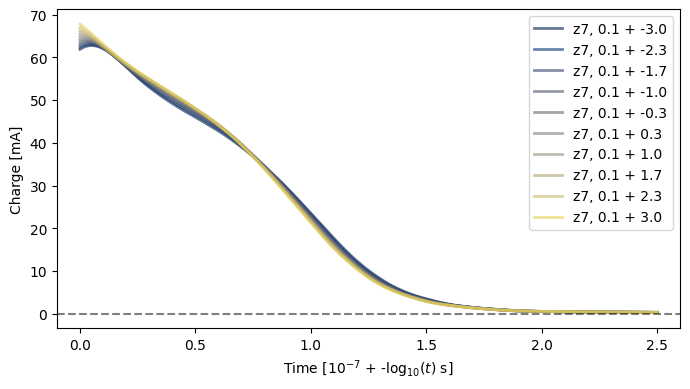

---Visualising Latent Dimension 8---


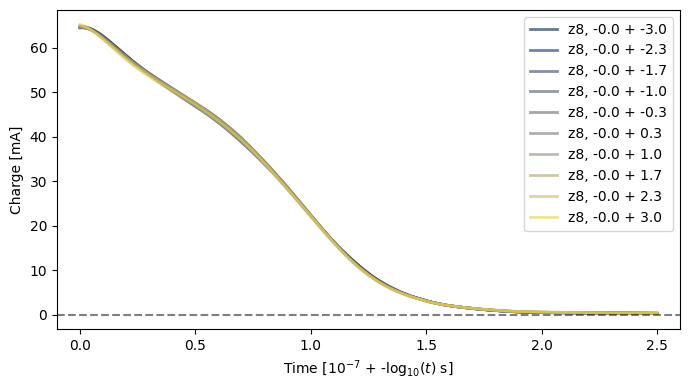

---Visualising Latent Dimension 9---


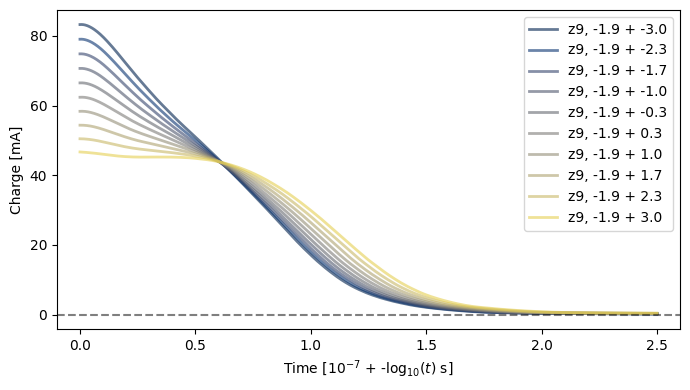

---Visualising Latent Dimension 10---


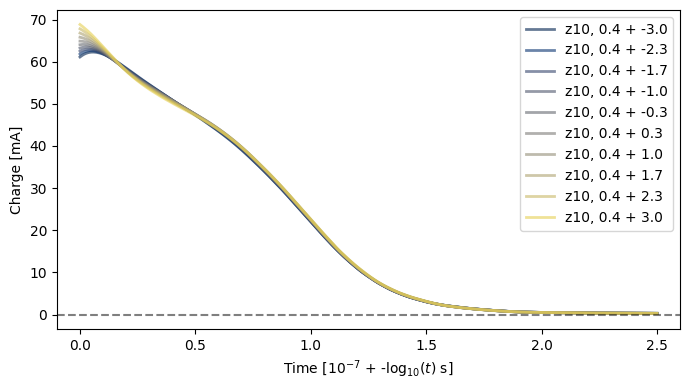

---Visualising Latent Dimension 11---


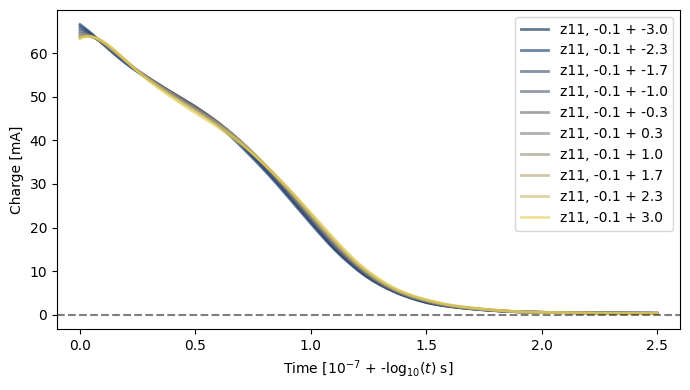

---Visualising Latent Dimension 12---


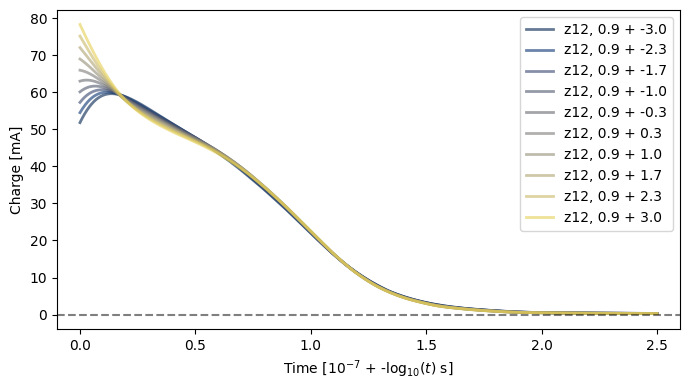

---Visualising Latent Dimension 13---


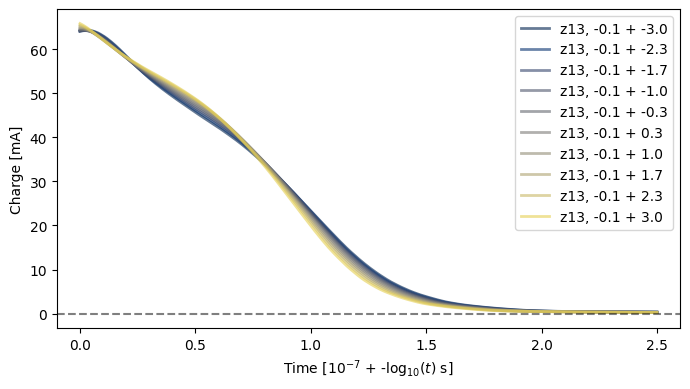

---Visualising Latent Dimension 14---


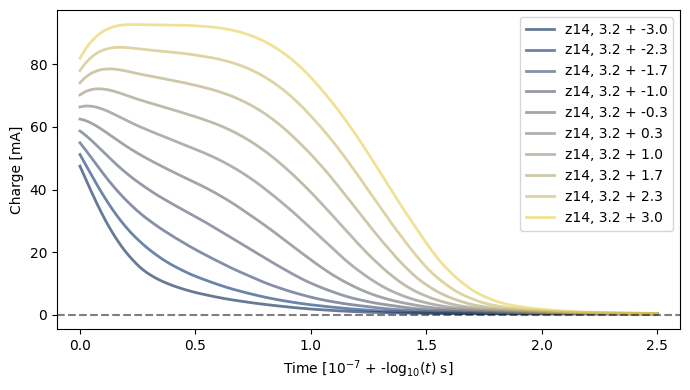

---Visualising Latent Dimension 15---


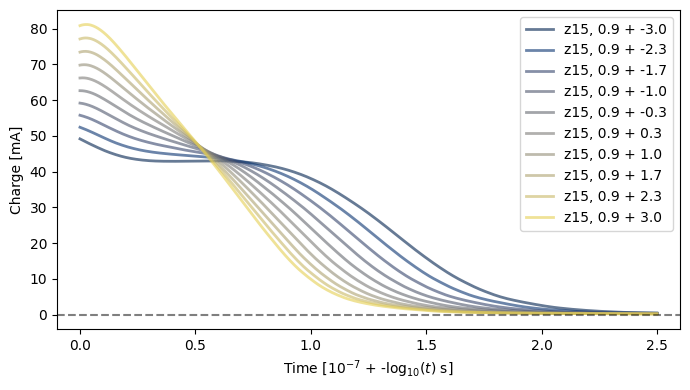

In [14]:
latent_variance = []
timestep_interest = 0     #always 0 unless exclusively calculating latent variance.

latent_subject = all[122:123, timestep_interest, :]    #all[traj_idx, timestep_interest, :], default is all[:,0,:] which will mean over all samples.
                                                       # timestep_interest should always be 0, unless this fn is only used for calculating latent_variance
for dim_idx in range(model_params['latent_dim']):
    print(f"---Visualising Latent Dimension {dim_idx}---")
    latent_variance.append(ipynb_utils.sweep_latent_adaptive(parameters.model_params, parameters.dataset, dim_idx, latent_subject, all, save=False, show=True))

In [ ]:
def sweep_latent_adaptive(model_params, dataset, latent_dim_number, latent_vectors, all_latent_vectors, specific_traj_list=None, save=False, show=False):
    """
    Visualize the effect of varying a specific latent dimension.
    
    This function generates predictions by varying the value of a single latent
    dimension while keeping others fixed at their mean values. This helps understand
    what feature each latent dimension encodes.
    
    Parameters
    ----------
    model_params : dict
        Dictionary containing model parameters and components
        Required keys: 'func', 'rec', 'dec', 'optim', 'device', 'epochs', 
                        'latent_dim', 'folder'
    dataset : dict
        Dictionary containing dataset components
        Required keys: 'trajs', 'times', 'y'
    latent_dim_number : int
        Index of the latent dimension to vary
    
    Returns
    -------
    None
        The function creates and saves a plot but doesn't return any values
    """
    # Extract data from dataset
    trajectories = dataset['trajs']
    time_points = dataset['times']
    metadata = dataset['y']

    # Extract model components
    model_func = model_params['func']
    encoder = model_params['rec']
    decoder = model_params['dec']
    optimizer = model_params['optim']
    device = model_params['device']
    epoch_num = model_params['epochs']
    latent_dims = model_params['latent_dim']

    # Create inference function for trajectory encoding

    # Set up figure for latent dimension sweep visualization
    num_dims = trajectories[0].shape[-1]
    fig_width = 7
    fig_height = 4 * num_dims
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create subplot for plotting the predictions
    ax = fig.add_subplot(1, 1, 1)

    # Create inference function for latent space decoding
    infer_step_decode = shjnn.make_infer_step(
        model_func, encoder, decoder, optimizer, device, 
        input_mode='latent'
    )

    # Define range of values to test for the selected latent dimension
    range_size = 3  # +/- 3 standard deviations
    test_values = np.linspace(-range_size, range_size, 10)

    # Create colormap for the different test values
    color_norm = colors.Normalize(vmin=0, vmax=len(test_values))
    color_map = cmx.ScalarMappable(norm=color_norm, cmap='cividis')

    # Test each value in the range
    ref = None
    mse_list = []
    for i, test_value in enumerate(test_values):
        # Get color for this test value
        color = color_map.to_rgba(i)

        # Start with the mean latent vector from the dataset
        base_latent = np.expand_dims(np.mean(latent_vectors, 0), 0)
        
        # Modify the target dimension with the test value
        base_latent[..., latent_dim_number] += test_value
        
        # Convert to tensor and move to device
        latent_tensor = torch.Tensor(base_latent).to(device)

        # Create time points tensor
        pred_times = np.linspace(0, 2.5, 1000)
        time_tensor = torch.Tensor(pred_times).to(device)

        # Get model prediction from the modified latent vector
        pred_x, pred_z = infer_step_decode(latent_tensor, time_tensor)

        # Convert prediction to numpy for plotting
        pred_x_np = pred_x.detach().cpu().numpy()[0]

        # Plot the prediction for the first dimension
        label = 'z{}, {:.1f} + {:.1f}'.format(
            latent_dim_number, 
            np.mean(latent_vectors, 0)[latent_dim_number],
            test_value
        )
        ax.plot(pred_times, pred_x_np[:, 0], '-', 
               label=label, alpha=0.6, color=color, linewidth=2)
        
        #calculate MSE against reference.
        if ref is None:
            ref = pred_x
        else:
            mse_list.append(torch.nn.MSELoss()(pred_x, ref).cpu().item())
            
    # Add labels and formatting
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')

    # Add horizontal line at y=0
    plt.hlines(0., -.1, 2.6, colors='k', linestyle='--', alpha=0.5)
    plt.xlim(-.1, 2.6)
            
    plt.legend()
    plt.tight_layout()

    # Save the figure
    if show:
        plt.show()
    if save:
        save_dir = model_params['folder'] + '/latent_dims'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        fig.savefig(save_dir + f'/epoch_{epoch_num}_dim_{latent_dim_number}.png', dpi=300)
        
    return sum(mse_list)

In [14]:
# Test the time evolved sweep function
dim_idx = 0  # Example latent dimension
timesteps_of_interest = [0, 100, 200, 300, 400, 500, 600, 900, 999]  # Example timesteps to analyze (0 - 999)

print(f"---Visualising Time-Evolved Latent Dimension {dim_idx}---")
visualisation.time_evolved_sweep(
    parameters.model_params, 
    parameters.dataset, 
    dim_idx, 
    timesteps_of_interest, 
    save=False, 
    show=True
)

---Visualising Time-Evolved Latent Dimension 0---


KeyboardInterrupt: 

In [5]:
#sort latent vectors by latent_variance
Y = torch.tensor(latent_variance, dtype=torch.float)
sorted_idxs = Y.argsort(descending=True)
latent_sorted = latent[:, sorted_idxs]
all_sorted = all[:,:,sorted_idxs]


In [6]:
print(sorted_idxs)

tensor([14,  9,  0,  1,  5,  2,  6,  7,  8, 12, 15, 13, 11,  3, 10,  4])


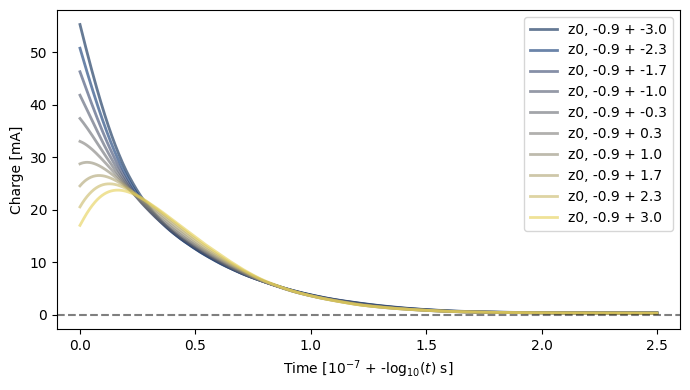

In [6]:
loss = ipynb_utils.sweep_latent_adaptive(parameters.model_params, parameters.dataset, 0, latent, all, save=False, show=True)

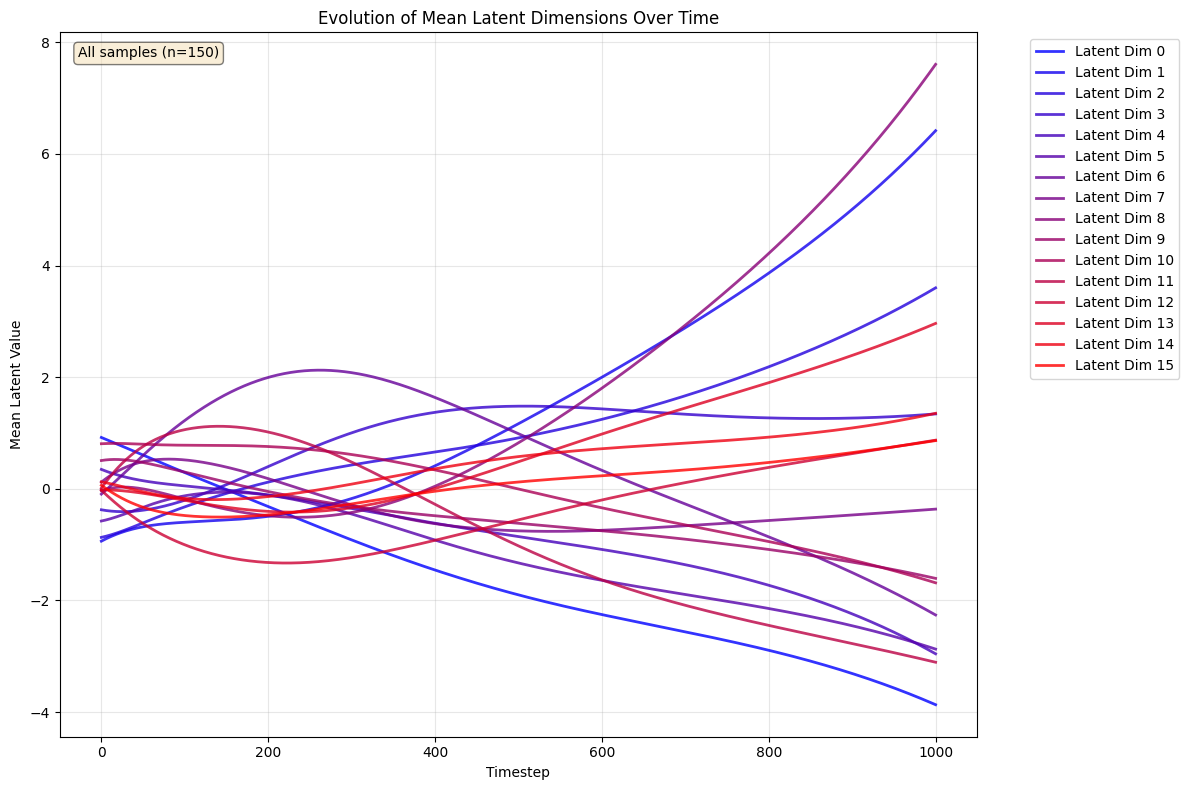

Plotted 16 latent dimensions over 1000 timesteps


In [7]:
# Plot latent trajectory evolution
# Show how all latent dimensions evolve over time

# Using all samples
ipynb_utils.latent_trajectory(all_sorted, sample_list=None, show=True, save=False)

# Example: Using only specific samples (e.g., first 10 samples)
# ipynb_utils.latent_trajectory(all, sample_list=list(range(10)), show=True, save=False)

# UMAP Encoding of the latent space.


/mnt/c/vscode/thesis/ML_charge_modeling/.wsl-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/c/vscode/thesis/ML_charge_modeling/.wsl-venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


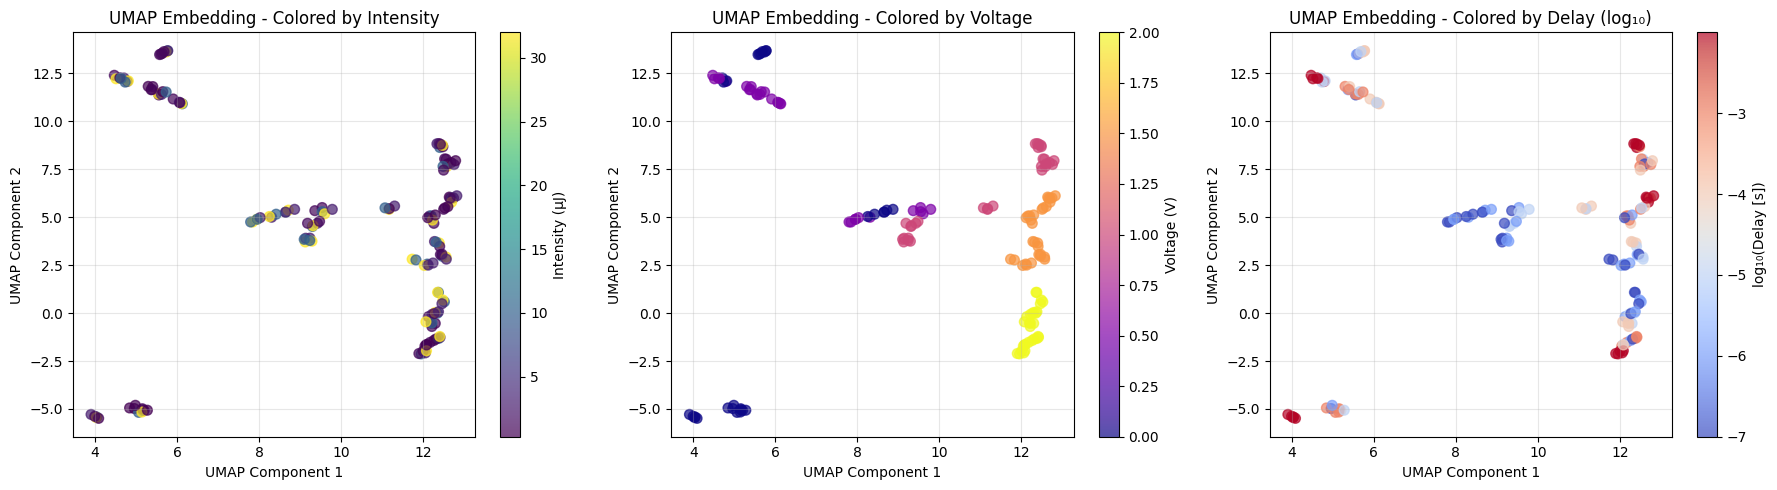

Original latent space shape: (150, 16)
UMAP embedding shape: (150, 2)
Intensity range: 0.30 to 32.00 μJ
Voltage range: 0.00 to 2.00 V
Delay range: 1.00e-07 to 1.00e-02 s
Log delay range: -7.0 to -2.0
Unique delay values: ['1.0e-07', '1.0e-06', '1.0e-05', '1.0e-04', '1.0e-03', '1.0e-02']


In [15]:
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the latent vectors
scaler = StandardScaler()
latent_scaled = scaler.fit_transform(latent)

# Apply UMAP dimensionality reduction
reducer = UMAP(n_components=2, random_state=0)
embedding = reducer.fit_transform(latent_scaled)

# Get metadata values for coloring
metadata = parameters.dataset['y'].cpu().numpy()  
intensities = [meta[0] for meta in metadata]  # INTENSITY = 0
voltages = [meta[1] for meta in metadata]     # VOLTAGE = 1
delays = [meta[2] for meta in metadata]       # DELAY = 2

# Convert delays to log scale for better visualization
log_delays = [np.log10(delay) if delay > 0 else np.nan for delay in delays]

# Create 3 subplots for intensity, voltage, and delay
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Colored by intensity
scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=intensities, cmap='viridis', alpha=0.7, s=50)
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].set_title('UMAP Embedding - Colored by Intensity')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='Intensity (μJ)')

# Plot 2: Colored by voltage
scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=voltages, cmap='plasma', alpha=0.7, s=50)
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].set_title('UMAP Embedding - Colored by Voltage')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Voltage (V)')

# Plot 3: Colored by delay (log scale)
scatter3 = axes[2].scatter(embedding[:, 0], embedding[:, 1], c=log_delays, cmap='coolwarm', alpha=0.7, s=50)
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')
axes[2].set_title('UMAP Embedding - Colored by Delay (log₁₀)')
axes[2].grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[2], label='log₁₀(Delay [s])')

plt.tight_layout()
plt.show()

print(f"Original latent space shape: {latent.shape}")
print(f"UMAP embedding shape: {embedding.shape}")
print(f"Intensity range: {min(intensities):.2f} to {max(intensities):.2f} μJ")
print(f"Voltage range: {min(voltages):.2f} to {max(voltages):.2f} V") 
print(f"Delay range: {min([d for d in delays if d > 0]):.2e} to {max(delays):.2e} s")
print(f"Log delay range: {min([d for d in log_delays if not np.isnan(d)]):.1f} to {max([d for d in log_delays if not np.isnan(d)]):.1f}")

# Show unique delay values for reference
unique_delays = sorted(list(set([d for d in delays if d > 0])))
print(f"Unique delay values: {[f'{d:.1e}' for d in unique_delays]}")